**Tea Bag Index to assess carbon decomposition rate in cranberry agroecosystems**

*Wilfried Dossou-Yovo, Serge Étienne Parent, Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [1]:
print(Sys.Date())

[1] "2021-07-26"


Table of content

# Objective

This notebook generates the results included in the manuscript *Organic matter decomposition kinetics in cranberry agroecosystem using the Tea Bag Index*. Two trials have been made, first one in 2017 (data_2017.csv) and the second in 2018 (data_2018.csv). Data set from trials are a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aim of this study was to assess carbon release rate in cranberry agroecosystems
compared to other terrestrial ecosystems

# Statistical questions

his notebook will answer the following statistical questions.

1. What is the influence of nitrogen fertilization on TBI parameters (k and S)?
2. Where cranberry soils are placed among the axes of the *TBI*?
3. What is the fractal kinetics of litter matterials ?
4. What is the fractal kinetics of litter biochemical composition ?

## Packages and Function

### Packages

We need package [plyr](https://www.rdocumentation.org/packages/plyr/versions/1.8.6) and [tidyverse](https://www.tidyverse.org/) for easy data manipulation. [tidyverse](https://www.tidyverse.org/) load a set of packages such as [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8) for data manipulation and [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1) for data visualization. A set of other packages is used: [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting nonlinear mixed-effects models, the [broom](https://www.rdocumentation.org/packages/broom/versions/0.7.0) package summarises model outputs in a "tidy" way, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) to test distributions, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) to avoid text overlaping on ggplot2, [patchwork](https://www.rdocumentation.org/packages/patchwork/versions/1.0.0/topics/patchwork-package) to assemble plots in grids.

In [1]:
#install.packages(c("e1071", "ggmap", "ggrepel", "patchwork", "tidyverse"))
library("plyr")
library("tidyverse")
library("nlme")
library("broom")
library("e1071")
library("ggmap")
library("ggrepel")
library("patchwork")

ERROR: Error: package or namespace load failed for ‘tidyverse’:
 .onAttach failed in attachNamespace() for 'tidyverse', details:
  call: library.dynam(lib, package, package.lib)
  error: shared object ‘cli.dylib’ not found


## Some custom functions.
### Pseudo R-square
Pseudo R-square allows to measure how well variables of our model explain organic matter decomposition

In [ ]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}

## Import data
Here, we load our data `data_2017.csv` available for the project in the `data` folder.

In [ ]:
df <- read_csv2("data/data_2017.csv")
df

## Mapping experimental sites

We design a map of our four experimental sites with geographical position collected from Stamen maps. Warnings appear, but it seems its a bug that comes out when mixing ggmap and geom_label_repel.

In [ ]:
arrowA <- data.frame(x1 = -58 , x2 = -70.5, y1 = 44, y2 = 46)
# table including sites and their geograhic position
sites <- tibble(names = c("Site #45", "Site #9", "Site #A9", "Site #10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 10)
par(mar = c(4, 4, 0.1, 0.1)) 
# create two frames, one for zoom out, the other for zoom in
frame_map_zoom_out <- c(left = -81, bottom = 40, right = -58, top = 50)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -70, top = 47)

# to draw the zoom in frame on the zoom out map
rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))

# the map with zoom out
map_out <- get_stamenmap(frame_map_zoom_out, zoom = 4, maptype = "toner-lite") %>%
  ggmap() +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top, 
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  #geom_label_repel(data = sites, aes(x = lon, y = lat, label = names), size = 8) +
  labs(x = "Longitude", y = "Latitude", title = "A") +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=12, face = "bold"),
        axis.title=element_text(size=14)) +
geom_segment(data=arrowA, aes(x=x1, y=y1, xend=x2, yend=y2), 
         arrow=arrow(ends="first"), colour="black", lineend = "round") 
# the map with zoom in
map_in <- get_stamenmap(frame_map_zoom_in, zoom = 8, maptype = "toner-lite") %>% # toner-lite
  ggmap() +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = names), size = 5, nudge_x = 0.5,
  nudge_y = 0.01, box.padding = 1.001, label.padding = 0.25, segment.linetype = 5) +
 geom_point(aes(x = lon, y = lat), data = sites, size = 2.5) +
  labs(x = "Longitude", y = "Latitude", title = "B") +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=12, face = "bold"),
        axis.title=element_text(size=14)) 
map_in

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 3)
maps_ <- map_out +  map_in 
maps_  
ggsave("figures/site_map.png", plot = maps_, width = 10, height = 3, dpi = 1200)

Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"
Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"
Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"
Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"


## Monthly weather data (2008-2018) at Lemieux, Quebec (46° 09′ 56″ N 72° 19′ 28″ W), for experimental sites (Gouvernement du Canada, 2018)

### Import data weather

`Data weather` has been collected from environnement canada. The content is the collection of data history about temperature and precipitation from years of field trial (2017 and 2018) and 10 years average (2008 to 2018).

In [8]:
df_weather <- read_csv2("data/data_weather.csv")

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  Years = col_character(),
  Months = col_character(),
  `Precipitations (mm)` = col_double(),
  `Temperatures (<U+623C><U+3E30>C)` = col_double()
)




### Plot weather data

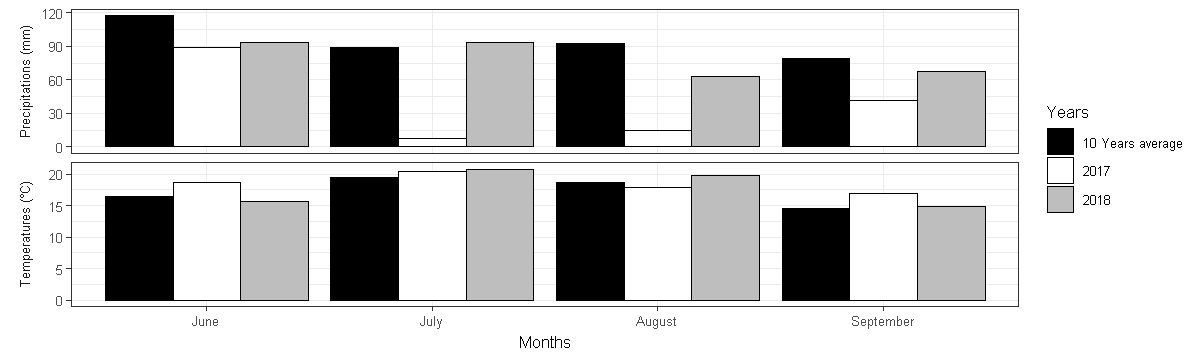

In [9]:
df_weather$Months <- factor(df_weather$Months,levels = c("June", "July", "August", "September")) #  Sorting bars by Months

df_weather_long <- df_weather %>%
  pivot_longer(cols = -c(Years, Months))

Weather <- df_weather_long %>%
  filter(Years %in% c("2017", "2018", "10 Years average")) %>%
  ggplot(aes(x = `Months`, y = value)) +
  facet_grid(name ~ ., scales = "free", switch = "y") +
  geom_bar(aes(fill= Years), colour = "black", stat="identity", position="dodge") +
  theme_bw() +
scale_fill_manual(values = c("black","white","grey")) +
  theme(axis.title.y = element_blank(),
        strip.background = element_rect(fill = "transparent", colour = "transparent"),
        strip.placement = "outside", text = element_text(size = 10))
Weather
ggsave("figures/Weather.png", plot = Weather, width = 5, height = 3, dpi = 120)

## Compute the 1st order kinetics

Weight loss rate has been estimated with the function

$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$,

where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [ ]:
kinetics_1st <- function(rw, iw, t) { # First order kinetic function
    -log(rw/iw)/t
}

We can compute `k1` for each row of the `df` table.

In [11]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## Data exploration

Computation of mean and standard deviation of two points (0-90 days) decomposition rate k1

In [12]:
k1_meanSD <- ddply(df, ~ `Tea type`,
      summarise, mean_k1 = mean(`k1`, na.rm = TRUE),sd_C_over_N=sd(`k1`,  na.rm = TRUE))
k1_meanSD

Tea type,mean_k1,sd_C_over_N
<chr>,<dbl>,<dbl>
Cranberry litter,0.0003861851,0.0008616747
Green tea,0.0097544883,0.0016809129
Rooibos tea,0.0033459356,0.0008833296


Computation of mean and standard deviation of initial and remaining tea weight after 90 days incubations time

In [13]:
data_weight_meanSD <- ddply(df, ~ `Tea type`,
      summarise, mean_Initial_weight = mean(`Initial tea weight (g)`, na.rm = TRUE), 
                            sd_Initial_weight = sd(`Initial tea weight (g)`, na.rm = TRUE),
                            mean_Remaining_weight = mean(`Remaining tea weight (g)`, na.rm = TRUE),
                            sd_Remaining_weight = sd(`Remaining tea weight (g)`, na.rm = TRUE))
data_weight_meanSD

Tea type,mean_Initial_weight,sd_Initial_weight,mean_Remaining_weight,sd_Remaining_weight
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cranberry litter,1.908767,0.01567869,1.8492927,0.1329799
Green tea,1.778593,0.01394033,0.7482469,0.1228291
Rooibos tea,1.909222,0.01057108,1.4171176,0.1112034


Computation of mean and standard deviation of initial C over N ratio

In [14]:
Data_C_over_N <- read_csv2("data/data_C_over_N_initial.csv") %>%
mutate(C_over_N = Initial_Perc_C / Initial_Perc_N)
C_over_N_meanSD <- ddply(Data_C_over_N, ~ `Tea type`,
      summarise,mean_C_over_N=mean(`C_over_N`, na.rm = TRUE),sd_C_over_N=sd(`C_over_N`,  na.rm = TRUE))
C_over_N_meanSD

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  No = col_double(),
  TypeThe = col_character(),
  `Tea type` = col_character(),
  Producteur = col_character(),
  Champs = col_character(),
  Regie = col_character(),
  TypeAzote = col_character(),
  DoseN = col_double(),
  Repetition = col_double(),
  Initial_Perc_C = col_double(),
  Initial_Perc_N = col_double(),
  Initial_Perc_S = col_double()
)




Tea type,mean_C_over_N,sd_C_over_N
<chr>,<dbl>,<dbl>
Cranberry litter,65.89091,6.371452
Green tea,11.20573,1.224186
Rooibos tea,53.52753,9.284972


Boxplot of $k_1$ for different N dosages per litter.

Warning message:
"Removed 23 rows containing non-finite values (stat_boxplot)."


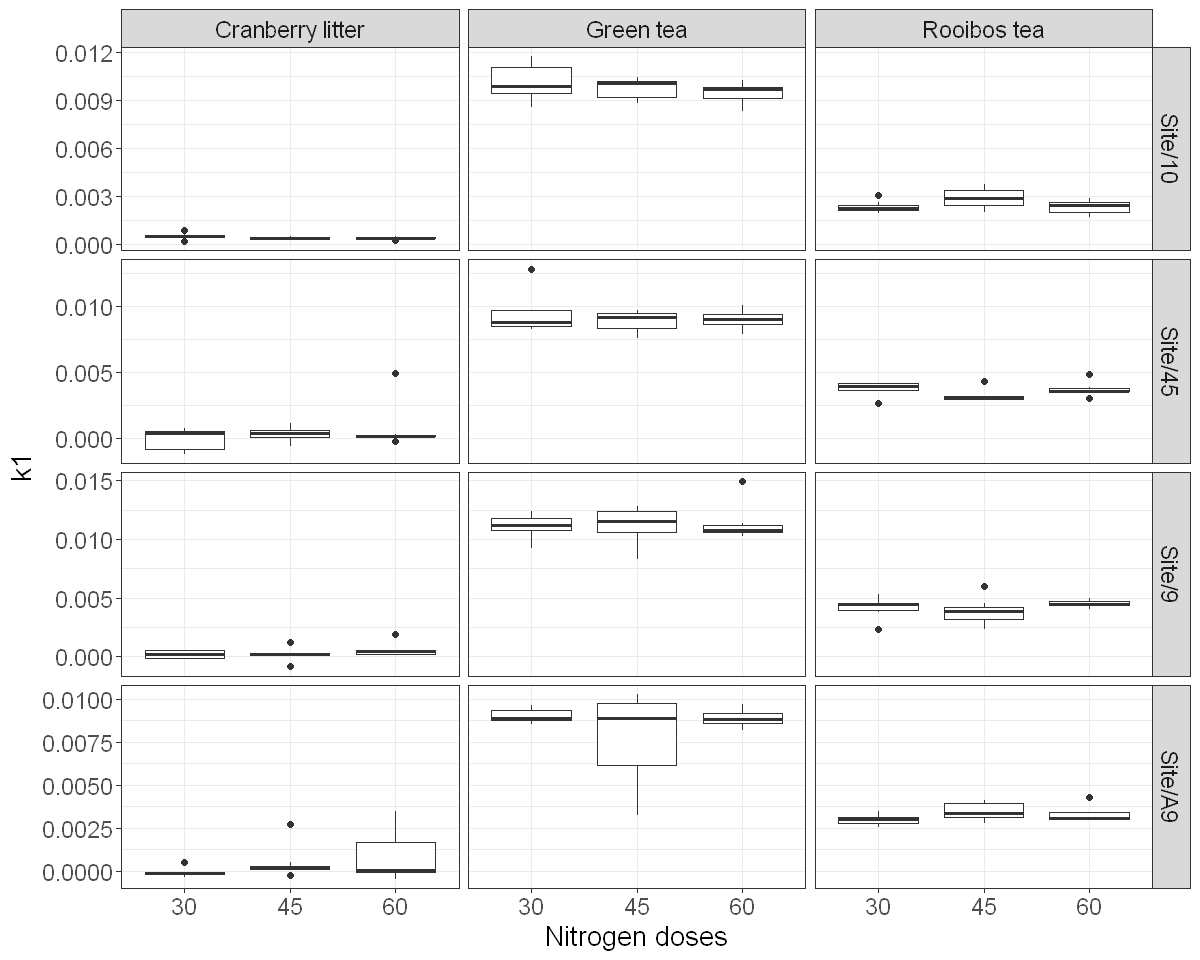

In [15]:
options(repr.plot.width = 10, repr.plot.height = 8)
New.labs <- c("Site/10", "Site/45", "Site/9", "Site/A9") # Change labels 
names(New.labs) <- c("10", "45", "9", "A9")
ggplot(data = df,
       mapping = aes(x = as.factor(`Nitrogen dose`), y = k1)) +
 geom_boxplot() +
  facet_grid(Site ~ `Tea type`, scales = "free", labeller = labeller(Site = New.labs)) +
labs(x = "Nitrogen doses") +
theme_bw() +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=16),
     axis.title.y = element_text(size=16)) 

## Mixed model

## **Question 1**: What is the influence of nitrogen fertilization on TBI parameters (k and S)?

Adding `M / M0` variable to data `df`.

In [16]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

I store hydrolysable fractions of green tea and rooibos.

In [17]:
Hf_g <- 0.805   # Hydrolysable fraction for Green tea
Hf_r <- 0.826   # Hydrolysable fraction for Rooibos tea

For comparaison purpose, [Keuskamp et al. (2013)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12097) hydrolysable fractions were:

- Green tea `Hf_g = 0.842`  
- Rooibos tea `Hf_r = 0.552`

### Computation of the labile fraction (a) and the stabilization factor (s) of green tea

Decomposition rate `k_tbi` is computed from Rooibos tea after 90 days of incubation. The *TBI* assumes that the decomposition of Green tea has stablilized while Rooibos tea is still decomposing. Stabilization factor `S` is computed from Green tea.

In [18]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

Compute litter stability `Sg` (Green tea) and decomposition constant `k_tbi` (Rooibos) for each experimental unit.

In [19]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

In [20]:
# Initialize k_tbi column
df$k_tbi <- NA

# For each rep, compute a and k_tbi
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

In [21]:
K_tbi_S_meanSD <- ddply(df, ~ `Tea type`,
      summarise, mean_K_tbi = mean(`k_tbi`, na.rm = TRUE), 
                            sd_K_tbi = sd(`k_tbi`, na.rm = TRUE),
                            mean_S = mean(`S`, na.rm = TRUE),
                            sd_S = sd(`S`, na.rm = TRUE))
K_tbi_S_meanSD

Tea type,mean_K_tbi,sd_K_tbi,mean_S,sd_S
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cranberry litter,NaN,NA,NaN,NA
Green tea,NaN,NA,0.2802262,0.08595211
Rooibos tea,0.006563192,0.002073537,NaN,NA


### What affecting TBI parameter decomposition rate (k)?

Because `k_tbi` is computed from Rooibos tea, we create a new Rooibos data table named `df_rooibos`.

In [22]:
df_rooibos <- df %>% 
  filter(`Tea type` == "Rooibos tea")

TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(`Ntype` = `Nitrogen type`,
         `Ndose` = `Nitrogen dose`)
TBI_data <- TBI_data %>%  
drop_na() %>%
  droplevels()

TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

### `k_tbi` mixed model

lme_TBI model investigates the magnitude of the dose (`Ndose`) on `k_tbi`, considering the random effect of sites (`Site`)

In [23]:
TBI_rooibos <- TBI_rooibos %>%
mutate(log = log(k_tbi))
lme_TBI <- lme (log ~  Ndose, 
               random = ~ 1 | Site, 
    data = TBI_rooibos)

In [24]:
summary(lme_TBI)

Linear mixed-effects model fit by REML
  Data: TBI_rooibos 
       AIC      BIC    logLik
  29.23211 38.90747 -10.61605

Random effects:
 Formula: ~1 | Site
        (Intercept)  Residual
StdDev:   0.2274628 0.2395634

Fixed effects:  log ~ Ndose 
                Value  Std.Error DF   t-value p-value
(Intercept) -5.198405 0.15038005 80 -34.56845  0.0000
Ndose        0.003086 0.00211625 80   1.45825  0.1487
 Correlation: 
      (Intr)
Ndose -0.631

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.42462710 -0.65390187 -0.07675473  0.60081810  2.92740766 

Number of Observations: 85
Number of Groups: 4 

### Pseudo r-square

Pseudo r-square was 0.01 with and 0.45 without random effect indicated the influence of random effects was impotant. 

In [25]:
pseudoR2(y = TBI_rooibos$log,
         y_hat = predict(lme_TBI, level = 0))

pseudoR2(y = TBI_rooibos$log,
         y_hat = predict(lme_TBI, level = 1))

[1] 0.01107845

[1] 0.4530537

### Shapiro-Wilk normality test
Our data were normaly distributed as shown by the following residues plot 

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.98693, p-value = 0.5511

[1] "Kurtosis: -0.324713934613358"
[1] "Skewness: -0.121097388651243"


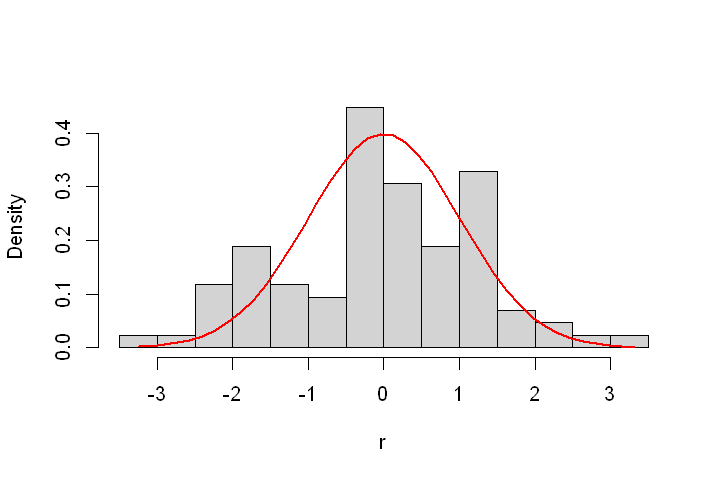

In [26]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(lme_TBI)

### Reporting the results of the mixed models
I create a table including the results I need: estimates, confidence intervals and p-values.

In [27]:
k_tbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
k_tbi_gg <- k_tbi_gg %>%
  mutate(variable = rownames(k_tbi_gg))
k_tbi_gg <- k_tbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Adding random effects to the table.

In [28]:
intervals(lme_TBI)
ranef(lme_TBI)$`(Intercept)`

Approximate 95% confidence intervals

 Fixed effects:
                   lower         est.        upper
(Intercept) -5.497670873 -5.198405035 -4.899139197
Ndose       -0.001125443  0.003086023  0.007297489
attr(,"label")
[1] "Fixed effects:"

 Random Effects:
  Level: Site 
                     lower      est.    upper
sd((Intercept)) 0.09827762 0.2274628 0.526461

 Within-group standard error:
    lower      est.     upper 
0.2051808 0.2395634 0.2797076 

[1] -0.33187047  0.12770506  0.11076003  0.09340537

In [29]:
k_tbi_re <- data.frame(matrix(ncol = ncol(k_tbi_gg), nrow = 4))
names(k_tbi_re) <- names(k_tbi_gg)
k_tbi_re$est. <- ranef(lme_TBI)$`(Intercept)`
k_tbi_re$variable <- rownames(ranef(lme_TBI))
k_tbi_re

if (!("Belanger" %in% k_tbi_gg$variable)) k_tbi_gg <- bind_rows(k_tbi_gg, k_tbi_re) # with an if to make sure ranefs are stacked only once

lower,est.,upper,variable,pvalue,is_significant
<lgl>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>
NA,-0.33187047,NA,10,NA,NA
NA,0.12770506,NA,45,NA,NA
NA,0.11076003,NA,9,NA,NA
NA,0.09340537,NA,A9,NA,NA


In [30]:
k_tbi_gg$variable <- c("Intercept",  # Change variable names
                        "Dose N",
                        "site #10", "site #45", "site #9", "site #A9")

Create a facet column to separate effects by effect category in the plot.

In [31]:
k_tbi_gg$facet <- factor(c('Intercept',
                        "Nitrogen dose",
                           "Random effect", "Random effect", "Random effect", "Random effect"))

k_tbi_gg <- k_tbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", 
                                              "Nitrogen dose", "Intercept"))))
k_tbi_gg

,lower,est.,upper,variable,pvalue,is_significant,facet
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<fct>
(Intercept),-5.497670873,-5.198405035,-4.899139197,Intercept,7.349407e-50,Significant at 0.05 level,Intercept
Ndose,-0.001125443,0.003086023,0.007297489,Dose N,1.486858e-01,Not significant at 0.05 level,Nitrogen dose
...3,NA,-0.331870467,NA,site #10,NA,NA,Random effect
...4,NA,0.127705060,NA,site #45,NA,NA,Random effect
...5,NA,0.110760034,NA,site #9,NA,NA,Random effect
...6,NA,0.093405373,NA,site #A9,NA,NA,Random effect


The `k_tbi_gg` table is now set up for the plot.

Warning message:
"Removed 4 rows containing missing values (geom_segment)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


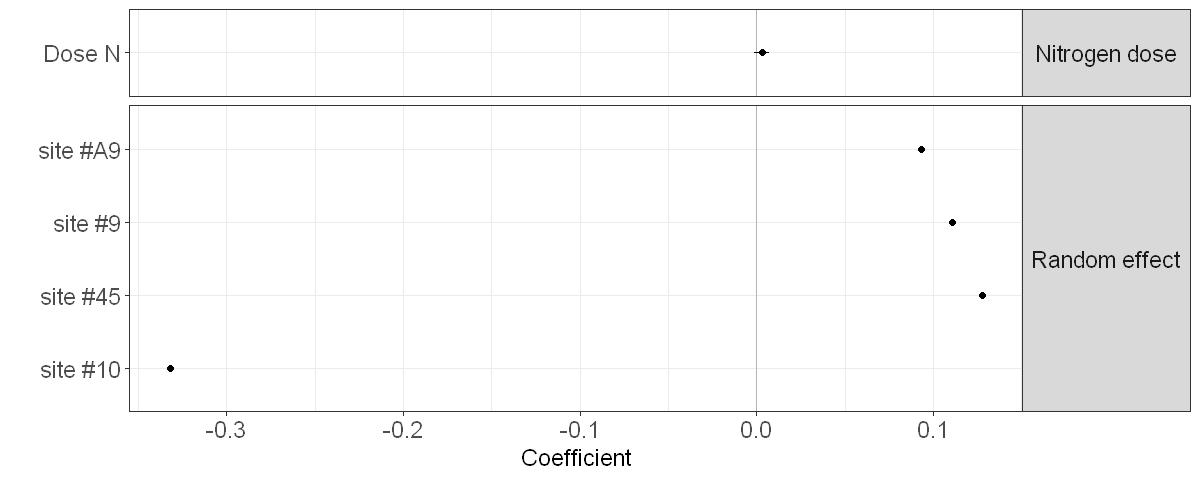

In [33]:
options(repr.plot.width = 10, repr.plot.height = 4)
plot_k_tbi_model <- k_tbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom", strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=14)) 
plot_k_tbi_model
  ggsave("figures/k_tbi-mixed-model-coefficients.png", plot = plot_k_tbi_model, width = 10, height = 4, dpi = 600)

### What affecting TBI parameter stabilization factor (S)?

Because `S` is computed from Green tea, we create a new Green data table named `df_green`.

In [34]:
df_green <- df %>% 
  filter(`Tea type` == "Green tea")

S_data <- df %>%
  select(S, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) 
S_data <- S_data %>%
  drop_na() %>%
  droplevels()

S_Green <- S_data %>%
  filter(`Tea type` == "Green tea")

### `S` mixed model

lme_S model investigates the magnitude of the dose (`Ndose`) on `S`, considering the random effect of sites (`Site`)

In [35]:
S_Green <- S_Green%>% 
mutate(log = log(S))

In [36]:
S_Green <- S_Green%>% 
mutate(log = log(S))

In [37]:
lme_S <- lme (log ~  Ndose, 
               random = ~ 1 | Site, 
    data = S_Green )

In [38]:
summary(lme_S)

Linear mixed-effects model fit by REML
  Data: S_Green 
       AIC      BIC    logLik
  24.93149 34.40928 -8.465746

Random effects:
 Formula: ~1 | Site
        (Intercept)  Residual
StdDev:   0.2008001 0.2342948

Fixed effects:  log ~ Ndose 
                 Value  Std.Error DF   t-value p-value
(Intercept) -1.3626927 0.14210876 76 -9.589083    0.00
Ndose        0.0013701 0.00217167 76  0.630888    0.53
 Correlation: 
      (Intr)
Ndose -0.683

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-4.08191446 -0.39071373 -0.02084241  0.41862266  3.16880092 

Number of Observations: 81
Number of Groups: 4 

### Pseudo r-square

Pseudo r-square was 0.01 with and 0.4 without random effect indicated the influence of random effects was impotant. 

In [39]:
pseudoR2(y = S_Green$log,
         y_hat = predict(lme_S, level = 0))

pseudoR2(y = S_Green$log,
         y_hat = predict(lme_S, level = 1))

[1] 0.005017486

[1] 0.3917774

### Shapiro-Wilk normality test
Our data were normaly distributed as shown by the following residues plot 

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.90532, p-value = 1.844e-05

[1] "Kurtosis: 4.01438471717064"
[1] "Skewness: -0.467798066057914"


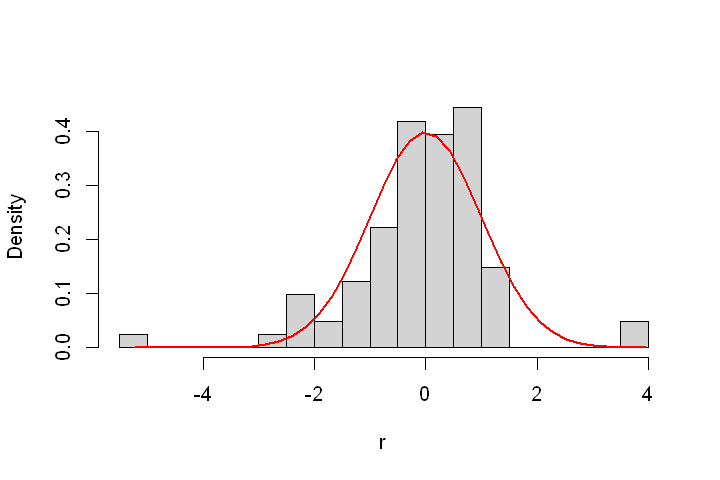

In [40]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(lme_S)

### Reporting the results of the mixed models
I create a table including the results I need: estimates, confidence intervals and p-values.

In [41]:
S_tbi_gg <- data.frame(intervals(lme_S, which = "fixed")$fixed)
S_tbi_gg <- S_tbi_gg %>%
  mutate(variable = rownames(S_tbi_gg))
S_tbi_gg <- S_tbi_gg %>%
  mutate(pvalue = summary(lme_S)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Adding random effects to the table.

In [42]:
S_tbi_re <- data.frame(matrix(ncol = ncol(S_tbi_gg), nrow = 4))
names(S_tbi_re) <- names(S_tbi_gg)
S_tbi_re$est. <- ranef(lme_S)$`(Intercept)`
S_tbi_re$variable <- rownames(ranef(lme_S))
S_tbi_re

if (!("Belanger" %in% S_tbi_gg$variable)) S_tbi_gg <- bind_rows(S_tbi_gg, S_tbi_re) # with an if to make sure ranefs are stacked only once

lower,est.,upper,variable,pvalue,is_significant
<lgl>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>
NA,-0.003696603,NA,10,NA,NA
NA,0.089219883,NA,45,NA,NA
NA,-0.268151265,NA,9,NA,NA
NA,0.182627986,NA,A9,NA,NA


In [43]:
S_tbi_gg$variable <- c("Intercept",  # Change variable names
                        "Dose N",
                        "site #10", "site #45", "site #9", "site #A9")

Create a facet column to separate effects by effect category in the plot.

In [44]:
S_tbi_gg$facet <- factor(c('Intercept',
                        "Nitrogen dose",
                           "Random effect", "Random effect", "Random effect", "Random effect"))

S_tbi_gg <- S_tbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", 
                                              "Nitrogen dose", "Intercept"))))
S_tbi_gg

,lower,est.,upper,variable,pvalue,is_significant,facet
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<fct>
(Intercept),-1.645726830,-1.362692702,-1.079658574,Intercept,1.001048e-14,Significant at 0.05 level,Intercept
Ndose,-0.002955178,0.001370082,0.005695343,Dose N,5.300065e-01,Not significant at 0.05 level,Nitrogen dose
...3,NA,-0.003696603,NA,site #10,NA,NA,Random effect
...4,NA,0.089219883,NA,site #45,NA,NA,Random effect
...5,NA,-0.268151265,NA,site #9,NA,NA,Random effect
...6,NA,0.182627986,NA,site #A9,NA,NA,Random effect


The `S` table is now set up for the plot.

Warning message:
"Removed 4 rows containing missing values (geom_segment)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


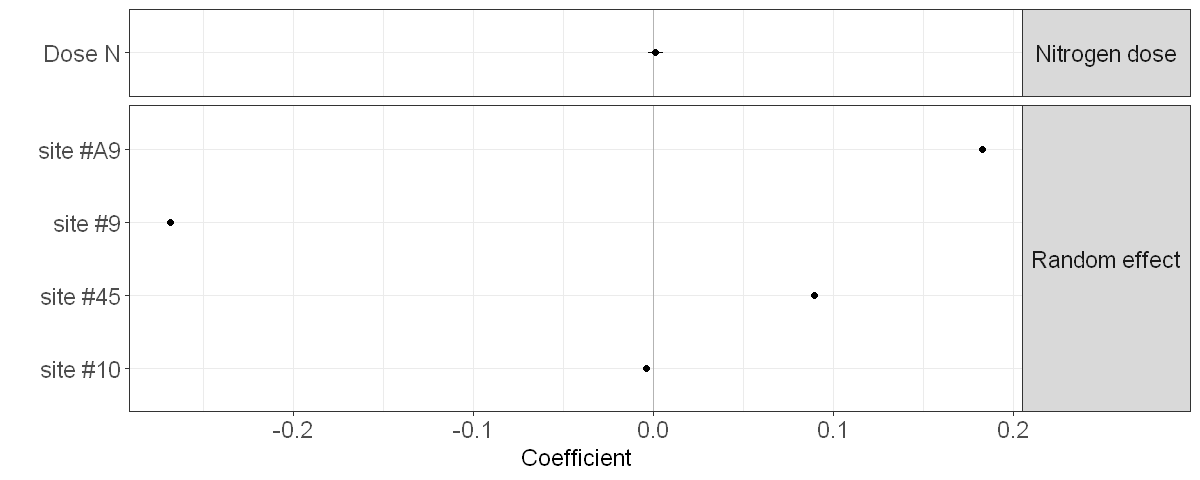

In [46]:
options(repr.plot.width = 10, repr.plot.height = 4)
plot_S_tbi_model <- S_tbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom", strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=14)) 
plot_S_tbi_model
  ggsave("figures/S_tbi-mixed-model-coefficients.png",plot = plot_S_tbi_model, width = 10, height = 4, dpi = 600)

## **Question 2**: Where cranberry soils are placed among the axes of the *TBI*?

Here, we extracted data from Keuskamp et al.2013 in order to compare with cranberry ecosystem

### Import data

We adapted keuskamp's data by adding cranberry ecosystem

In [47]:
df_keuskamp <- read_csv2("data/keuskamp_data.csv")# Import Keuskamp data
head(df_keuskamp)

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  SE_Stabilisation_factor = col_double(),
  Decomposition_rate_K = col_double(),
  SE_K = col_double()
)




Nombre,Region,Stabilisation_factor_S,SE_Stabilisation_factor,Decomposition_rate_K,SE_K
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,US-FL mangrove-dwarf,0.270600,0.028990,0.0097505,0.0006525
2,US-FL mangrove-fringe,0.193400,0.009620,0.0230000,0.0016800
3,IE peat-disturbed,0.255000,0.022870,0.0092889,0.0003730
4,IE peat-undisturbed,0.198120,0.008700,0.0101330,0.0005600
5,IS grassland-warmed,0.038384,0.012029,0.0196000,0.0004380
6,IS grassland-ambient,0.162970,0.017390,0.0211000,0.0014390


Create a logic column (`is_cranberry`) in order to identify `Cranberries` by color in the plot below

In [48]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries",
        Region_2 = paste(Nombre, Region, sep = " - "),
        Region_2 = factor(Region_2, levels = as.vector(Region_2))) # Relevel group factor
                         

### Figure TBI

TBI of Quebec cranberry agroecosystem compared to the TBI of ecosystems reported by Keuskamp et al 2013. United States–Florida = US-FL, China = CN, Panama = PA, the Netherlands = NL, Austria = AU, Ireland = IE, and Iceland = IS.

In [49]:
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) + 
geom_errorbar(aes(xmin = Stabilisation_factor_S - SE_Stabilisation_factor, xmax = Stabilisation_factor_S + 
                SE_Stabilisation_factor,  width= 0.001)) + 
geom_errorbar(aes(ymin = Decomposition_rate_K- SE_K, ymax = Decomposition_rate_K + 
                SE_K,  width= 0.01)) + #
geom_rect(aes(xmin=Stabilisation_factor_S - SE_Stabilisation_factor, xmax=Stabilisation_factor_S + SE_Stabilisation_factor,
              ymin=Decomposition_rate_K- SE_K, ymax=Decomposition_rate_K + SE_K), fill="grey80", alpha=0.2) +
geom_point(aes( color = `Region_2`), size = 3) +
scale_x_continuous(breaks = 0.05*0:1000,
                   expand = expand_scale(add = 0.05)) +
scale_y_continuous(breaks = 0.005*0:1000,
                  expand = expand_scale(add = 0.005)) +
geom_text_repel(aes(label = Nombre)) + 
  theme_bw() +
 labs(x = expression(paste("Stabilization factor ",(italic("S")))), y = expression(paste("Decomposition rate ", (italic("k"))))) +
theme(legend.position = c(0.80, 0.60), legend.title = element_blank(),
     legend.text = element_text(size=14), axis.title=element_text(size=16), 
      axis.text=element_text(size=14)) +  
ggsave("figures/TBI_keuskamp.png", width = 10, height = 7, dpi = 600)

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."


ERROR: Error: Can't add `ggsave("figures/TBI_keuskamp.png", width = 10, height = 7, dpi = 600)` to a ggplot object.


### **Question 3**:What is the fractal kinetics of litter matterials ?

Depending on the nature of decaying material and its immediate environment, the decomposition rate of plant residues can decrease gradually through time as follow: 

$$k_t = k_1 t^{{-h}}$$

$$log \left( k_t \right) = log \left( k_1 t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) + log \left(t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) - h \times log \left(t\right)$$

Where $k_t$ is first order kinetics, $k_1$ is reaction rate at time t = 1 and $h$ is a fractal coefficient (0 ≤ h ≤ 1) accounting for the decreasing decomposition rate through time

#### Fractal coefficient computation

##### Import data

Fractal data set from 2018 trial contained information on `Final carbon (%)` `Final weight (g)` `Initial weight (g)` `Initial carbon (%)`   

In [55]:
data_fractal <- read_csv2("data/data_fractal.csv")
head(data_fractal)
dim(data_fractal)

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)




Tea type,Prelevement,Final carbon (%),Final weight (g),Initial weight (g),Initial carbon (%)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cranberry litter,1,52.97542,1.9686,1.893,50.003
Cranberry litter,1,52.97542,2.0006,1.938,50.003
Cranberry litter,1,52.97542,1.9766,1.923,50.003
Cranberry litter,1,52.97542,1.9657,1.901,50.003
Cranberry litter,1,52.97542,1.9817,1.907,50.003
Cranberry litter,1,52.97542,1.9845,1.909,50.003


[1] 2613    6

##### Adding some variables
`First order kinetic names (k)`, `log(k)` and `Log(t)` has been computed. Then we select the variables needed in order compute the fractal coefficient `h`

In [56]:
data_lm_fractal <- data_fractal %>%
  mutate(
    # time and k
    time = Prelevement * 21,
    k = -log(`Final weight (g)` / `Initial weight (g)`)/ time,
  ) %>%
  mutate(
    # log.time and log.k
    log.time = log10(time),
    log.k = log10(k)
  ) %>%
  select(`Tea type`, `k`,`log.time`, `log.k`, `time`)

Warning message in mask$eval_all_mutate(quo):
"production de NaN"


Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [57]:
fractal_kinetics <- tibble(
    tea_types = c("Rooibos tea", "Cranberry litter", "Green tea"),
    intercept_ll = NA,
    intercept = NA,
    intercept_ul = NA,
    slope_ll = NA,
    slope = NA,
    slope_ul = NA,
    r_sq = NA
)

```
lm(log.k ~ log.time)
k1 = 10^intercept
h = -slope
```


Computation of mean and sd value `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [58]:
log_meanSD <- ddply(data_lm_fractal, ~ time + `Tea type`,
      summarise, mean_log.time = mean(`log.time`, na.rm = TRUE), 
                            sd_log.time = sd(`log.time`, na.rm = TRUE),
                            mean_log.k = mean(`log.k`, na.rm = TRUE),
                            sd_log.k = sd(`log.k`, na.rm = TRUE))
head(log_meanSD)

,time,Tea type,mean_log.time,sd_log.time,mean_log.k,sd_log.k
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,Cranberry litter,1.322219,0,-3.128705,0.60730982
2,21,Green tea,1.322219,0,-1.689927,0.14969712
3,21,Rooibos tea,1.322219,0,-2.232980,0.12904149
4,42,Cranberry litter,1.623249,0,-2.963006,0.98060354
5,42,Green tea,1.623249,0,-1.849784,0.04160770
6,42,Rooibos tea,1.623249,0,-2.366805,0.09285622


In [59]:
data_median_lm_fractal <- aggregate(cbind(log.time, log.k) ~ time + `Tea type`, data = data_lm_fractal, FUN = mean)
head(data_median_lm_fractal)

,time,Tea type,log.time,log.k
,<dbl>,<chr>,<dbl>,<dbl>
1,21,Cranberry litter,1.322219,-3.128705
2,42,Cranberry litter,1.623249,-2.963006
3,63,Cranberry litter,1.799341,-3.746522
4,84,Cranberry litter,1.924279,-3.503940
5,105,Cranberry litter,2.021189,-3.119618
6,126,Cranberry litter,2.100371,-3.023068


Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1` by `tea type`

In [60]:
conf_level <- 0.95

for (i in 1:nrow(fractal_kinetics)) {
    
    lm_fractal <- log_meanSD %>%
      filter(`Tea type` == fractal_kinetics$tea_types[i]) %>%
      lm(`mean_log.k` ~ `mean_log.time`, data = .)
    
    # intercept
    fractal_kinetics$intercept_ll[i] <- confint(lm_fractal, level = conf_level)[1, 1]
    fractal_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_kinetics$intercept_ul[i] <- confint(lm_fractal, level = conf_level)[1, 2]
    
    # Slope
    fractal_kinetics$slope_ll[i] <- confint(lm_fractal, level = conf_level)[2, 1]
    fractal_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_kinetics$slope_ul[i] <- confint(lm_fractal, level = conf_level)[2, 2]
    
    # statistics
    fractal_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared
}

In [61]:
fractal_kinetics <-  fractal_kinetics %>%
  mutate(h_ll = -slope_ul,
         h = -slope,
         h_ul = -slope_ll,
         k1_ll = 10^intercept_ll,
         k1 = 10^intercept,
        k1_ul = 10^intercept_ul)%>%
  select(tea_types, r_sq, h_ll, h, h_ul, k1_ll, k1, k1_ul)
fractal_kinetics

tea_types,r_sq,h_ll,h,h_ul,k1_ll,k1,k1_ul
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rooibos tea,0.936885569,0.2608088,0.37172296,0.4826371,1.123358e-02,0.0181173410,0.02921936
Cranberry litter,0.004550046,-1.2131348,-0.06738182,1.0783711,3.304020e-06,0.0004606007,0.06421056
Green tea,0.979448280,0.5179839,0.62147514,0.7249664,9.181530e-02,0.1434165853,0.22401839


Fractal first order parameters of teas and cranberry litter decomposition under field conditions

In [62]:
log_meanSD <- subset(log_meanSD, `Tea type` == "Green tea" | `Tea type` == "Rooibos tea") 
fractal_kinetics2 <- subset(fractal_kinetics, tea_types == "Green tea" | tea_types == "Rooibos tea")
log_meanSD

,time,Tea type,mean_log.time,sd_log.time,mean_log.k,sd_log.k
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2,21,Green tea,1.322219,0,-1.689927,0.14969712
3,21,Rooibos tea,1.322219,0,-2.232980,0.12904149
5,42,Green tea,1.623249,0,-1.849784,0.04160770
6,42,Rooibos tea,1.623249,0,-2.366805,0.09285622
8,63,Green tea,1.799341,0,-1.927068,0.05339011
9,63,Rooibos tea,1.799341,0,-2.380447,0.06285834
11,84,Green tea,1.924279,0,-2.018993,0.07034026
12,84,Rooibos tea,1.924279,0,-2.467779,0.07414211
14,105,Green tea,2.021189,0,-2.079947,0.07228345


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



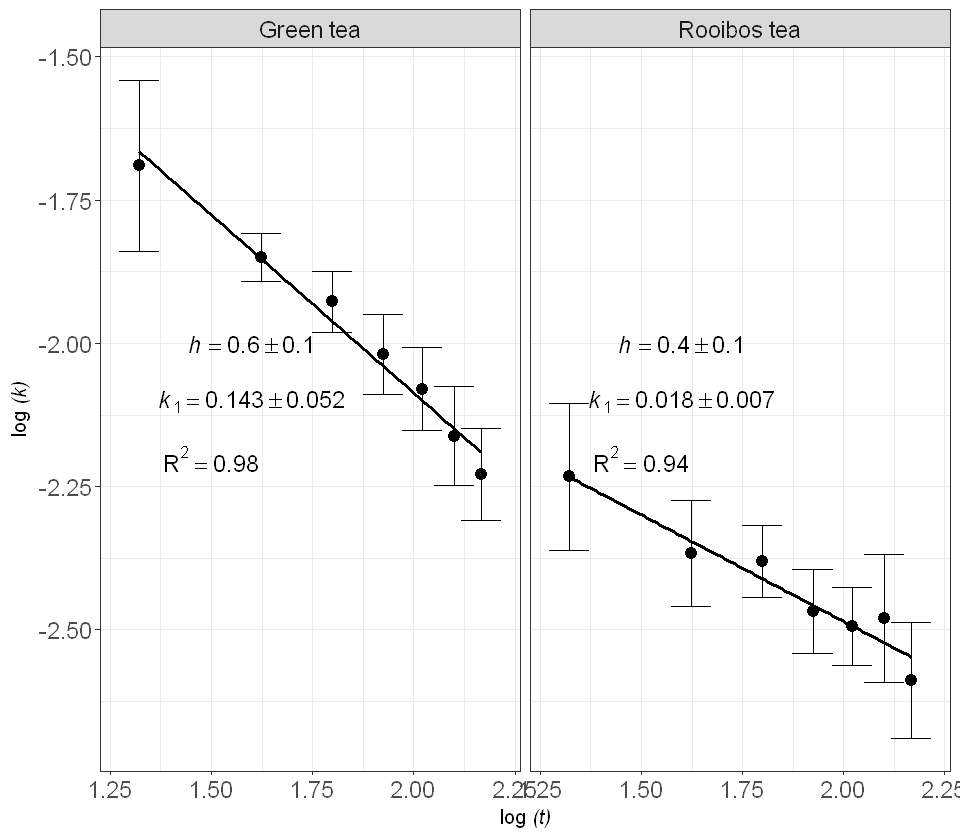

In [64]:
options(repr.plot.width = 8, repr.plot.height = 7)
log_meanSD %>%
  ggplot(aes(x = mean_log.time, y  = mean_log.k)) +
  geom_smooth(method = "lm", se = FALSE, colour="black") +
  geom_errorbar(aes(ymin=`mean_log.k`- `sd_log.k`, ymax=`mean_log.k` + 
                 `sd_log.k`,  width= 0.1)) + #, alpha=0.9, size=1.5,  width=3
geom_point(size = 3) + 
 facet_grid(. ~ `Tea type`) +
  geom_text(data = fractal_kinetics2 %>%
             rename(`Tea type`= tea_types),
            parse = TRUE,
            aes(label = paste("italic(h) ==", round(h, 1), "%+-%", round(h-h_ll, 1))), 
            x = 1.60, y = -2, size = 5) + #
  geom_text(data = fractal_kinetics2 %>%
             rename(`Tea type`= tea_types),  
            parse = TRUE,
            aes(label = paste(("italic(k[1]) =="), round(k1, 3), "%+-%", round(k1- k1_ll, 3))),
            x = 1.60, y = -2.1, size = 5) +
geom_text(data = fractal_kinetics2 %>%
              rename(`Tea type`= tea_types),
          parse = TRUE,
            aes(label = paste(("R^2 =="), round(r_sq, 2))),
            x = 1.5, y = -2.2, size = 5) +
labs(x = expression(paste("log ",italic("(t)"))), y=expression(paste("log ",italic("(k)")))) +
  theme_bw() + 
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
        axis.title=element_text(size=12)) 
ggsave("figures/Fractal first order parameters of teas and cranberry litter decomposition under field conditions.png",
       width = 8, height = 7, dpi = 600)

## Estimation of the carbon decreasing rate of teas and cranberry residue

Reaction rate $k_1$ at time t = 1 and fractal coefficient $h$

In [65]:
fractal_kinetics

tea_types,r_sq,h_ll,h,h_ul,k1_ll,k1,k1_ul
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rooibos tea,0.936885569,0.2608088,0.37172296,0.4826371,1.123358e-02,0.0181173410,0.02921936
Cranberry litter,0.004550046,-1.2131348,-0.06738182,1.0783711,3.304020e-06,0.0004606007,0.06421056
Green tea,0.979448280,0.5179839,0.62147514,0.7249664,9.181530e-02,0.1434165853,0.22401839


In [66]:
k1_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(k1)

k1_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(k1)

k1_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(k1)

h_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(h)

h_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(h)

h_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(h)

Computing  $k_t$ for each tea type and renaming somes variables to be able to group plot

$$k_t = k_1 t^{{-h}}$$

In [67]:
data_rate <- data.frame(Prelevement = 1:7) %>%
                            mutate(`Time (days)` = Prelevement * 21,
                                  `Rate cranberry` = k1_cranberry *  `Time (days)`**-h_cranberry,
                                  `Rate rooibos` = k1_rooibos * `Time (days)`**-h_rooibos,
                                  `Rate green` = k1_green * `Time (days)`**-h_green) %>%
                            rename(`Cranberry litter` = `Rate cranberry`,
                                  `Rooibos tea` = `Rate rooibos`,
                                   `Green tea` = `Rate green`)
data_rate

Prelevement,Time (days),Cranberry litter,Rooibos tea,Green tea
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,0.0005654811,0.005842452,0.021620859
2,42,0.0005925187,0.004515392,0.014053687
3,63,0.0006089300,0.003883634,0.010923302
4,84,0.0006208490,0.003489761,0.009134981
5,105,0.0006302545,0.003211974,0.007952075
6,126,0.0006380450,0.003001501,0.007100212
7,147,0.0006447069,0.002834346,0.006451572


Tranforming data_rate into long format data in order to generate the plot

In [68]:
names(data_lm_fractal)
unique(data_lm_fractal$`Tea type`)
dim(data_lm_fractal)

[1] "Tea type" "k"        "log.time" "log.k"    "time"

[1] "Cranberry litter" "Rooibos tea"      "Green tea"

[1] 2613    5

In [69]:
data_long <- gather(data = data_rate, key = `tea type`, value = Rate, c(`Cranberry litter`, `Rooibos tea`, `Green tea`),
                    factor_key=TRUE)
data_long <- data_long %>%
             rename(`Litter type`= `tea type`)

Plot of litter decomposition rate over time under field conditions

In [70]:
meanSD_rate_weight_loss <- ddply(data_lm_fractal, ~ `Tea type` + `time`,
      summarise, mean_rate_weight_loss = mean(`k`, na.rm = TRUE), 
                            sd_rate_weight_loss = sd(`k`, na.rm = TRUE))
head(meanSD_rate_weight_loss)

,Tea type,time,mean_rate_weight_loss,sd_rate_weight_loss
,<chr>,<dbl>,<dbl>,<dbl>
1,Cranberry litter,21,-0.0016906719,0.0026021076
2,Cranberry litter,42,-0.0005611653,0.0017503227
3,Cranberry litter,63,0.0001183135,0.0004344189
4,Cranberry litter,84,0.0004121479,0.0005298686
5,Cranberry litter,105,0.0008068256,0.0003542452
6,Cranberry litter,126,0.0009773839,0.0002714074


In [71]:
names(meanSD_rate_weight_loss)

[1] "Tea type"              "time"                  "mean_rate_weight_loss"
[4] "sd_rate_weight_loss"

In [72]:
#install.packages("ggrepel")
#library("ggrepel")
data_label <- meanSD_rate_weight_loss                              # Modify data
data_label$label <- NA
data_label$label[which(data_label$`time` == max(data_label$`time`))] <- data_label$`Tea type`[which(data_label$`time` == max(data_label$`time`))]


In [73]:
data_label$`Tea type`[which(data_label$`time` == max(data_label$`time`))]
data_label$label[which(data_label$`time` == max(data_label$`time`))]
which(data_label$`time` == max(data_label$`time`))
names(data_label)

[1] "Cranberry litter" "Green tea"        "Rooibos tea"

[1] "Cranberry litter" "Green tea"        "Rooibos tea"

[1]  7 14 21

[1] "Tea type"              "time"                  "mean_rate_weight_loss"
[4] "sd_rate_weight_loss"   "label"

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



List of 3
 $ axis.title:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.text :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ strip.text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL

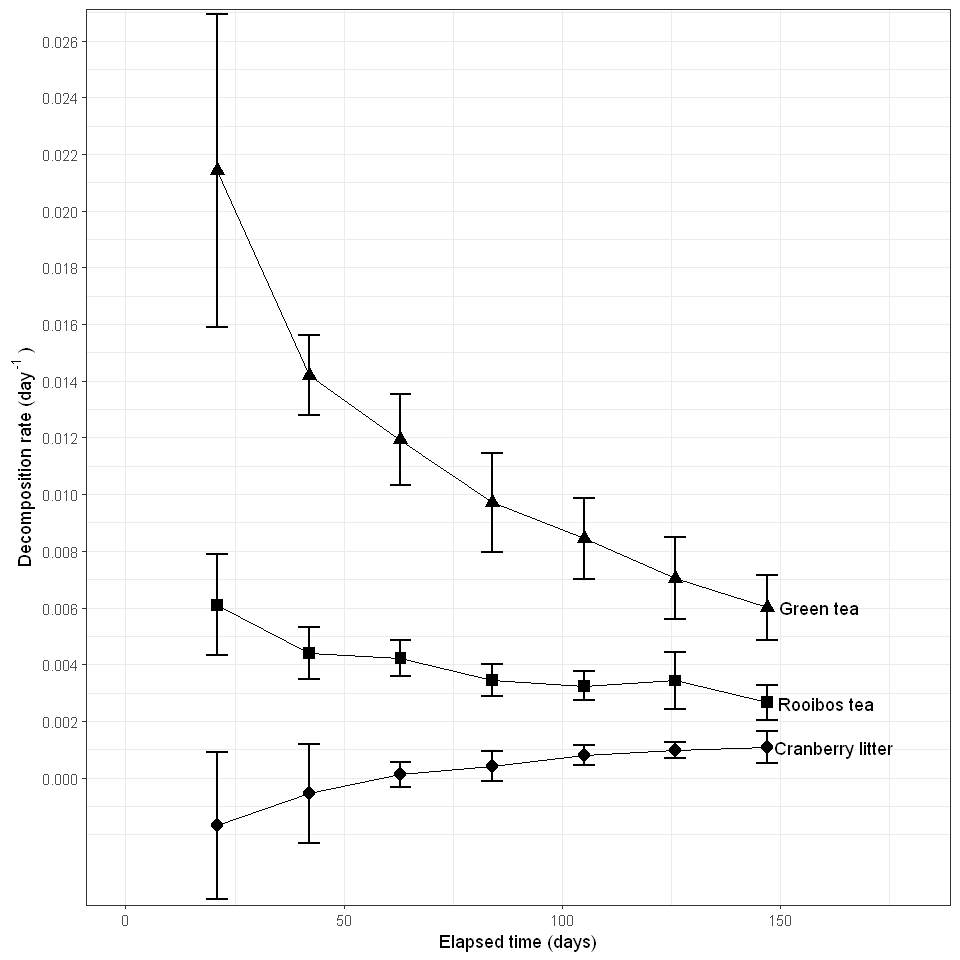

In [93]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot <- ggplot(data_label, aes(x = `time`, y = `mean_rate_weight_loss`, group = `Tea type`)) +
geom_line() +
geom_errorbar(aes(ymin=`mean_rate_weight_loss`- `sd_rate_weight_loss`, ymax=`mean_rate_weight_loss` + 
                 `sd_rate_weight_loss`), width=5, alpha= 1, size=0.6) + 
geom_point(aes(shape = `Tea type`), size = 3)+
geom_text_repel(aes(label = label), nudge_x = 1, force_pull = -0.03,
                 min.segment.length = 0.7, na.rm = TRUE) + 
labs(x = "Elapsed time (days)" , y = expression("Decomposition rate (day"^" -1"~")"))  +
scale_y_continuous(breaks = 0.002*0:1000,
                     expand = expand_scale(add = 0.0002)) +
scale_x_continuous(breaks = 10*0:1000,
                     expand = expand_scale(add = 10)) +
 xlim(c(0,180)) +
theme_bw() #+
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14), #legend.text = element_text(size=14),
      #legend.title = element_text(size=14),
        axis.title=element_text(size=14)) #+
plot + theme(legend.position = "none")
ggsave("figures/K(t).png", width = 10, height = 7, dpi = 600)

## 12. **Question 4**: What is the fractal kinetics of litter biochemical composition ?

### 12.1 Biochemical composition data analysis 
Here, we load `data.csv`, `data_fiber_initial.csv` and `data_fiber.csv`available for the project in the `data` folder. The `data_2018.csv` contained incubation tea bag details and soil carateristics from the second essay in 2018; `data_fiber_initial.csv` contained only initial tea bag caracteristics and `data_fiber.csv` contained mostly tea bag biochemical details as soluble, holocellulose and lignin content. 
We wanted to use only data about `green tea`, `rooibos tea` and `cranberry residu`. In order to do that, we used `subset` function to get `data_subset`

In [142]:
data <- read_csv2('data/data_2018.csv', col_types = "??????????????f????????????????????")
data_fiber <- read_csv('data/data_fiber.csv')
data_fiber_initial2 <- read_csv2('data/Initial_biochemical_composition.csv')
names(data_fiber_initial2)

i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  `Iden fiber` = col_character(),
  `SOL perc ILR (%)` = col_double(),
  `HOLO perc ILR (%)` = col_double(),
  `LIC perc ILR (%)` = col_double()
)


i Using ',' as decimal and '.' as grouping mark. Use `read_delim()` for more control.


-- Column specification --------------------------------------------------------
cols(
  `Biomasse type` = col_character(),
  Repetition = col_double(),
  `SOL perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double()
)




[1] "Biomasse type"         "Repetition"            "SOL perc initial (%)" 
[4] "LIC perc initial (%)"  "HOLO perc initial (%)"

In [143]:
Biochemical_meanSD <- ddply(data_fiber_initial2, ~ `Biomasse type`,
      summarise, `mean_SOL_initial (%)` = mean(`SOL perc initial (%)`, na.rm = TRUE), 
                            `sd_SOL_initial (%)` = sd(`SOL perc initial (%)`, na.rm = TRUE),
                            `mean_LIC_initial (%)` = mean(`LIC perc initial (%)`, na.rm = TRUE),
                            `sd_LIC_initial (%)` = sd(`LIC perc initial (%)`, na.rm = TRUE),
                            `mean_HOLO_initial (%)` = mean(`HOLO perc initial (%)`, na.rm = TRUE),
                            `sd_HOLO_initial (%)` = sd(`HOLO perc initial (%)`, na.rm = TRUE))
Biochemical_meanSD

data_fiber_initial <- Biochemical_meanSD %>%
rename(`Biomass type` = `Biomasse type`)

Biomasse type,mean_SOL_initial (%),sd_SOL_initial (%),mean_LIC_initial (%),sd_LIC_initial (%),mean_HOLO_initial (%),sd_HOLO_initial (%)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cranberry litter,33.98039,3.315563,40.062538,2.748850,25.95707,0.8640548
Green tea,75.20968,1.530771,9.983044,1.439903,14.80727,0.8841235
Rooibos tea,45.44203,1.363677,17.071021,1.060403,37.48695,0.3033845


In [144]:
data_subset <- subset(data,  (`Sampling period (3 weeks)`> 0 & `Sampling period (3 weeks)`<= 7 & (`Biomass type`== "Cranberry litter" | 
`Biomass type` == "Green tea"| `Biomass type` == "Rooibos tea")))

Join all 3 data with with `left_join` function. The obtained data is called `data_join_02`

In [145]:
data_join <- data_subset %>%
  left_join(data_fiber, by = 'Iden fiber')

data_join_02 <- data_join %>%
  left_join(data_fiber_initial, by = 'Biomass type')%>%
mutate(`Sample final weight (g)` = as.numeric(`Sample final weight (g)`),
       `Sample final weight (g)` = as.numeric(`Sample final weight (g)`),
       `Sample final weight (g)` = as.numeric(`Sample final weight (g)`))

## Some calculations 
### Initial and final content of carbon, soluble, holocellulose and lignin

In [146]:
data_join_02 <- data_join_02 %>%
mutate(`Initial SOL content (g)` = `mean_SOL_initial (%)` * `Sample initial weight (g)` / 100,
       `Initial HOLO content (g)` = `mean_HOLO_initial (%)` * `Sample initial weight (g)` / 100,
       `Initial LIC content (g)` = `mean_LIC_initial (%)` * `Sample initial weight (g)` / 100,
       `Final SOL content (g)` = `SOL perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final LIC content (g)` = `LIC perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final HOLO content (g)` = `HOLO perc ILR (%)` * `Sample final weight (g)` / 100,
       `Initial Hydrolyzable content (g)` = `Initial SOL content (g)` +  `Initial HOLO content (g)`,
       `Final Hydrolyzable content (g)` = `Final SOL content (g)` + `Final HOLO content (g)`)

### First order kinetic
Here,we compute decomposition rate of carbon, soluble, holocellulose and lignin using first order kinetic.

In [147]:
kinetics_1st <- function(rw, iw, t) { # first order kinetic function
    -log10(rw/iw)/t
}

In [148]:
data_join_02 <- data_join_02 %>%
mutate(`rate weight loss` = kinetics_1st(rw = `Sample final weight (g)`,
                      iw = `Sample initial weight (g)`,
                      t = `Sampling period (3 weeks)` * 21),
    `rate SOL` = kinetics_1st(rw = `Final SOL content (g)`,
                      iw = `Initial SOL content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate HOLO` = kinetics_1st(rw = `Final HOLO content (g)`,
                      iw = `Initial HOLO content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate LIC` = kinetics_1st(rw = `Final LIC content (g)`,
                      iw = `Initial LIC content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate Hydrolyzable` = kinetics_1st(rw = `Final Hydrolyzable content (g)`,
                      iw = `Initial Hydrolyzable content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
      `Sampling period (days)` = `Sampling period (3 weeks)` * 21)

### Selection all variables we interested in data_join_02. Our final data is called `data_filtre`

In [149]:
na.action = na.exclude
data_filtre <- data_join_02 %>%
select(`Iden fiber`, `Biomass type`,  `Sampling period (days)`, `Site`, `Producer`,`Repetition`, #`C_over_N`,
 `Initial SOL content (g)`, `Initial HOLO content (g)`, `Initial LIC content (g)`, `Final SOL content (g)`,`Final HOLO content (g)`, `Final LIC content (g)`,
       `Sample final weight (g)`, `Initial Hydrolyzable content (g)`, `Final Hydrolyzable content (g)`, 
       `rate SOL`, `rate HOLO`, `rate LIC`, `rate Hydrolyzable`, `rate weight loss`) %>% 
rename(Lignin = `rate LIC`, 
       Holocelulose = `rate HOLO`, 
       Soluble = `rate SOL`,
       Hydrolyzable = `rate Hydrolyzable`)

In [150]:
meanSD_rate_weight_loss <- ddply(data_filtre, ~ `Biomass type` + `Sampling period (days)`,
      summarise, mean_rate_weight_loss = mean(`rate weight loss`, na.rm = TRUE), 
                            sd_rate_weight_loss = sd(`rate weight loss`, na.rm = TRUE))
head(meanSD_rate_weight_loss)

,Biomass type,Sampling period (days),mean_rate_weight_loss,sd_rate_weight_loss
,<chr>,<dbl>,<dbl>,<dbl>
1,Cranberry litter,21,-7.342495e-04,0.0011300810
2,Cranberry litter,42,-2.437110e-04,0.0007601555
3,Cranberry litter,63,5.138291e-05,0.0001886657
4,Cranberry litter,84,1.789935e-04,0.0002301190
5,Cranberry litter,105,3.503999e-04,0.0001538468
6,Cranberry litter,126,4.686477e-04,0.0001810546


## Biochemical fractal kinetics

Transforming `data_filtre` to long format data `data_long` in order to use a `facet_grid` in the plot below

In [104]:
data_long <- gather(data = data_filtre, key = `Biochemical composition`, value = `Biochemical decomposition rate`, c(`Soluble`,
                                                                                                                    `Lignin`, `Holocelulose`, `Hydrolyzable`),
                    factor_key=TRUE)

Extract data_long according to biomass type `Rooibos and Green tea`; and Biochemical composition `Lignin and Hydrolyzable` fraction

In [105]:
data_long <- subset(data_long, `Biomass type` == "Green tea" | `Biomass type` == "Rooibos tea")
data_long <- subset(data_long, `Biochemical composition` == "Lignin" | `Biochemical composition` == "Hydrolyzable")

In [106]:
data_long <- data_long %>%
        mutate(`log.K` = log10(`Biochemical decomposition rate`),
                `log.T` = log10(`Sampling period (days)`))

Warning message in mask$eval_all_mutate(quo):
"production de NaN"


Create new facet names for variable `Biochemical composition`

In [107]:
New.labs <- c("Non-Hydrolyzable", "Hydrolyzsable") 
names(New.labs) <- c("Lignin", "Hydrolyzable")

Selection of all variables needed in `data_lm_fractal_biochemical`

In [108]:
data_lm_fractal_biochemical <- data_long %>%
  select(`Biomass type`, `Biochemical decomposition rate`, `log.T`, `log.K`, `Biochemical composition`, `Sampling period (days)`)

Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [109]:
fractal_biochemical_kinetics <- tibble(
    `Biomass type` = c("Green tea", "Rooibos tea", "Green tea", "Rooibos tea"),
    Biochemical_composition = c(rep("Lignin", 2), rep("Hydrolyzable", 2)),
    intercept_ll = NA,
    intercept = NA,
    intercept_ul = NA,
    slope_ll = NA,
    slope = NA,
    slope_ul = NA,
    r_sq = NA
)

```
lm(log.K ~ log.T)
K1 = 10^intercept
h = -slope
```


Computation of median value of `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [110]:
MeanSD_fractal_biochemical <- ddply(data_lm_fractal_biochemical, ~ `Sampling period (days)` + `Biomass type` + `Biochemical composition`,
      summarise, mean_log.T = mean(`log.T`, na.rm = TRUE), 
                            sd_log.T = sd(`log.T`, na.rm = TRUE),
                            mean_log.K = mean(`log.K`, na.rm = TRUE), 
                            sd_log.K = sd(`log.K`, na.rm = TRUE))
head(MeanSD_fractal_biochemical)


,Sampling period (days),Biomass type,Biochemical composition,mean_log.T,sd_log.T,mean_log.K,sd_log.K
,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,Green tea,Lignin,1.322219,0,-2.099202,0.35635431
2,21,Green tea,Hydrolyzable,1.322219,0,-2.001934,0.10923547
3,21,Rooibos tea,Lignin,1.322219,0,-2.586387,0.22445100
4,21,Rooibos tea,Hydrolyzable,1.322219,0,-2.515667,0.09687986
5,42,Green tea,Lignin,1.623249,0,-2.971281,0.49431959
6,42,Green tea,Hydrolyzable,1.623249,0,-2.138982,0.04681782


Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1`; by `Biomass type` and `Biochemical composition`

In [111]:
conf_level <- 0.95

for (i in 1:nrow(fractal_biochemical_kinetics)) {
    
    lm_fractal <- data_median_fractal_biochemical %>%
      filter((`Biomass.type` == fractal_biochemical_kinetics$`Biomass type`[i]) &
             (`Biochemical.composition` == fractal_biochemical_kinetics$Biochemical_composition[i])) %>%
      lm(`log.K.Mean` ~ `log.T.Mean`, data = .)
    
    # interept
    fractal_biochemical_kinetics$intercept_ll[i] <- confint(lm_fractal, level = conf_level)[1, 1]
    fractal_biochemical_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_biochemical_kinetics$intercept_ul[i] <- confint(lm_fractal, level = conf_level)[1, 2]
    
    # slope
    fractal_biochemical_kinetics$slope_ll[i] <- confint(lm_fractal, level = conf_level)[2, 1]
    fractal_biochemical_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_biochemical_kinetics$slope_ul[i] <- confint(lm_fractal, level = conf_level)[2, 2]
    
    # statistics
    fractal_biochemical_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared    
}

ERROR: Error in filter(., (Biomass.type == fractal_biochemical_kinetics$`Biomass type`[i]) & : objet 'data_median_fractal_biochemical' introuvable


Computation of `h`, r square `r_sq` and `k1`; by `Biomass type` and `Biochemical composition`

In [222]:
fractal_biochemical_kinetics <- fractal_biochemical_kinetics %>%
  mutate(h_ll = -slope_ul,
         h = -slope,
         h_ul = -slope_ll,
         k1_ll = 10^intercept_ll,
         k1 = 10^intercept,
         k1_ul = 10^intercept_ul) %>%
  select(`Biomass type`,
         Biochemical_composition,
         r_sq,
         h_ll, h, h_ul,
         k1_ll, k1, k1_ul)
fractal_biochemical_kinetics

Biomass type,Biochemical_composition,r_sq,h_ll,h,h_ul,k1_ll,k1,k1_ul
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Green tea,Lignin,0.7882732,0.49010593,1.2125145,1.9349231,0.0079781181,0.17942849,4.03536060
Rooibos tea,Lignin,0.8119037,0.19745040,1.7077339,3.2180174,0.0005197375,0.42879145,353.75951646
Green tea,Hydrolyzable,0.9680209,0.49540094,0.6262556,0.7571102,0.0415205238,0.07297227,0.12824868
Rooibos tea,Hydrolyzable,0.6889444,0.09616105,0.4226028,0.7490445,0.0034180509,0.01395455,0.05697087


Fractal first order parameters of decomposition of teas biochemicals compositions under field conditions

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



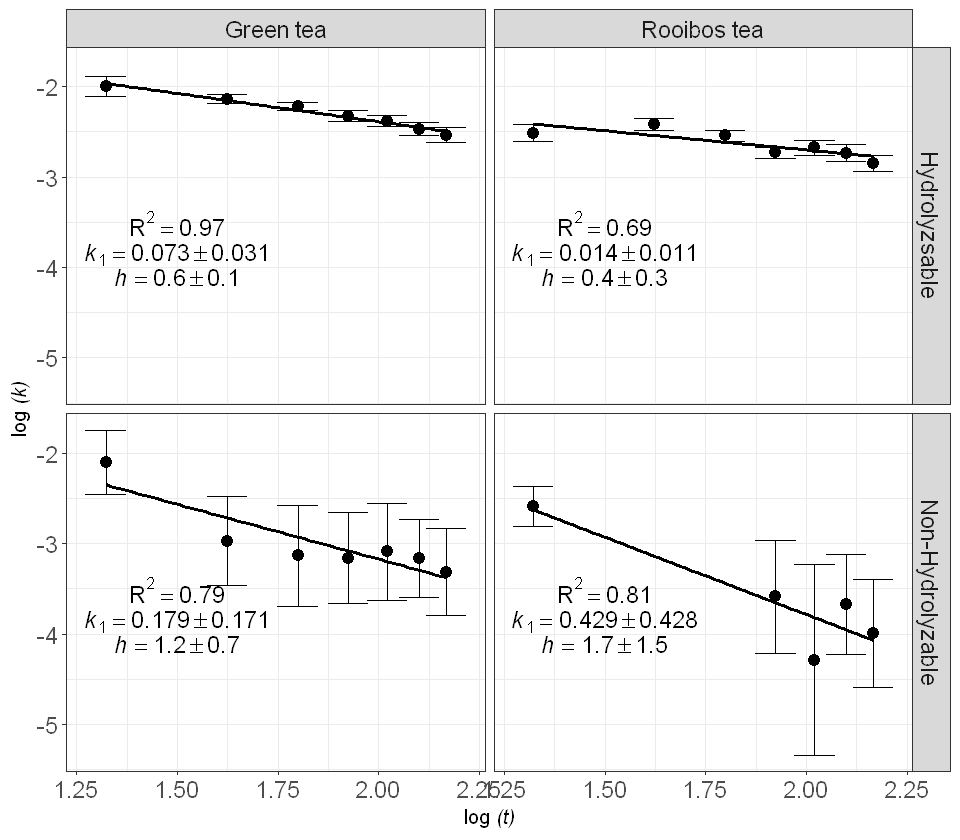

In [223]:
options(repr.plot.width = 8, repr.plot.height = 7)
data_median_fractal_biochemical %>%
  ggplot(aes(x = `log.T.Mean`, y  = `log.K.Mean`)) +
  geom_smooth(method = "lm", se = FALSE, colour="black") +
  geom_errorbar(aes(ymin= `log.K.Mean`- `log.K.SD`, ymax=`log.K.Mean` + 
                `log.K.SD`,  width= 0.1)) + #, alpha=0.9, size=1.5,  width=3
geom_point(size = 3) + 
  facet_grid(`Biochemical.composition` ~ `Biomass.type`, labeller = labeller(`Biochemical.composition` = New.labs)) +
  geom_text(data = fractal_biochemical_kinetics %>%
              rename(`Biochemical.composition`= Biochemical_composition, `Biomass.type` =  `Biomass type`),
            parse = TRUE,
          aes(label = paste("italic(h) ==", round(h, 1), "%+-%", round(h-h_ll, 1))),
            x = 1.5, y = -4.1, size = 5) +
  geom_text(data = fractal_biochemical_kinetics %>%
              rename(`Biochemical.composition`= Biochemical_composition, `Biomass.type` =  `Biomass type`),  
            parse = TRUE,
            aes(label = paste("italic(k[1]) ==", round(k1, 3), "%+-%", round(k1-k1_ll, 3))),
            x = 1.5, y = -3.85, size = 5) +

geom_text(data = fractal_biochemical_kinetics %>%
              rename(`Biochemical.composition`= Biochemical_composition, `Biomass.type` =  `Biomass type`),
         parse = TRUE,
          aes(label = paste(("R^2 =="), round(r_sq, 2))),                 
           x = 1.5, y = -3.5, size = 5) + 
labs(x = expression(paste("log ", italic("(t)"))), y = expression(paste("log ", italic("(k)")))) +
  theme_bw() +
theme(strip.text = element_text(size = 14), axis.text=element_text(size=14),
       axis.title=element_text(size=12)) 
ggsave("figures/Fractal first order parameters of decomposition of teas biochemicals compositions under field conditions.png", 
      width = 8, height = 7, dpi = 600)